In [73]:
%matplotlib inline
import geopandas as gpd
import pandas as pd

In [60]:
def ag_count(state):
    data = gpd.read_file("Data\\SoVI2010_" + state + "\\SoVI0610_" + state + ".shp")
    data['CTFIPS'] = data['STATEFP10'] + data['COUNTYFP10']
    data = data.groupby('CTFIPS').agg({"SOVI0610" + state: "mean", "P0010001": "sum"})
    data = data.rename(columns={"SOVI0610" + state: "SOVI"})
    return data

CA = ag_count("CA")
FL = ag_count("FL")
IN = ag_count("IN")
LA = ag_count("LA")
ME = ag_count("ME")
WA = ag_count("WA")
CA.head()

,P0010001,SOVI
CTFIPS,,
06001,1510271.0,-0.174812
06003,1175.0,0.686160
06005,38091.0,1.558083
06007,220000.0,1.954188
06009,45578.0,1.929986


In [61]:
sovi = CA.append([FL, IN, LA, ME, WA])
sovi = sovi.sort_values(by='CTFIPS')
sovi.head()

,P0010001,SOVI
CTFIPS,,
06001,1510271.0,-0.174812
06003,1175.0,0.686160
06005,38091.0,1.558083
06007,220000.0,1.954188
06009,45578.0,1.929986


In [68]:
fema = gpd.read_file("Data\\FEMA_6\\FEMA_6.shp")
fema = fema.merge(sovi, on="CTFIPS")

In [69]:
fema = fema.sort_values(by='CTFIPS')
fema.head()

,OBJECTID,STFIPS,ST_ABBR,CTFIPS,STATE,COUNTY,GEO_SUFFIX,TOTAL_DECL,FLOOD_1964,ICE_STORM_,...,COASTAL_19,EARTHQUA_1,REGION_NO,Shape_Leng,Winter_196,Shape_Le_1,Shape_Area,geometry,P0010001,SOVI
44,58,06,CA,06001,California,Alameda,County,14,3,0,...,0,0,9,3.610286,1,3.610286,0.196849,(POLYGON ((-121.9673689779958 37.4676361297038...,1510271.0,-0.174812
25,39,06,CA,06003,California,Alpine,County,6,3,0,...,0,0,9,2.174212,0,2.174212,0.199044,POLYGON ((-119.5854370003171 38.71321199963438...,1175.0,0.686160
7,21,06,CA,06005,California,Amador,County,9,3,0,...,0,0,9,2.909742,0,2.909742,0.161954,POLYGON ((-120.0723920002905 38.70276699999727...,38091.0,1.558083
39,53,06,CA,06007,California,Butte,County,10,3,0,...,0,0,9,4.205838,1,4.205838,0.455942,POLYGON ((-121.0766949997742 39.59726399983401...,220000.0,1.954188
8,22,06,CA,06009,California,Calaveras,County,8,1,0,...,0,0,9,2.963056,0,2.963056,0.276236,POLYGON ((-120.0199510002383 38.43352099969468...,45578.0,1.929986


In [76]:
fema.to_file("fema//fema.shp")
#fema.to_file("fema.csv")

DriverIOError: Failed to create file C:\Users\Macklan\School\geog-458\Final_Project\fema\fema.shp: No such file or directory

KeyError: 'sovi'

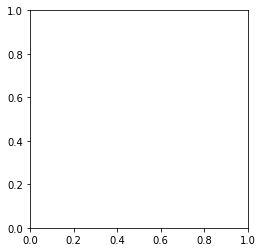

In [75]:
fema.plot(column='sovi', cmap='OrRd')